## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib

# from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.utils.franka import reconstruct_actions
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2024-08-16 16:10:05.789 | INFO     |  Running on cuda:0


In [3]:
task = 'Sweep'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)


2024-08-16 16:10:07.845 | INFO     |  Loading dataset(s): 
2024-08-16 16:10:07.846 | INFO     |    Initializing datasete using /home/hartzj/MT-GMM/data/Sweep/demos/metadata.json
2024-08-16 16:10:07.847 | INFO     |    Extracted gt object labels []
2024-08-16 16:10:07.847 | INFO     |    Extracted tsdf object labels []
2024-08-16 16:10:07.847 | INFO     |    Done! Data contains 4 trajectories.


In [4]:
kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'exp',
}


In [5]:
observations = scene_data.get_demos(**kp_config)

reconstruct_actions(observations)

n_obs = len(observations)


In [6]:
demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=True,
    enforce_z_down=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True,
    # kp_indeces=list(range(4)),
)

demos = Demos(observations, **data_kwargs)

2024-08-16 16:10:11.188 | INFO     |  Subsampling to length 272 using strategy mean-length.


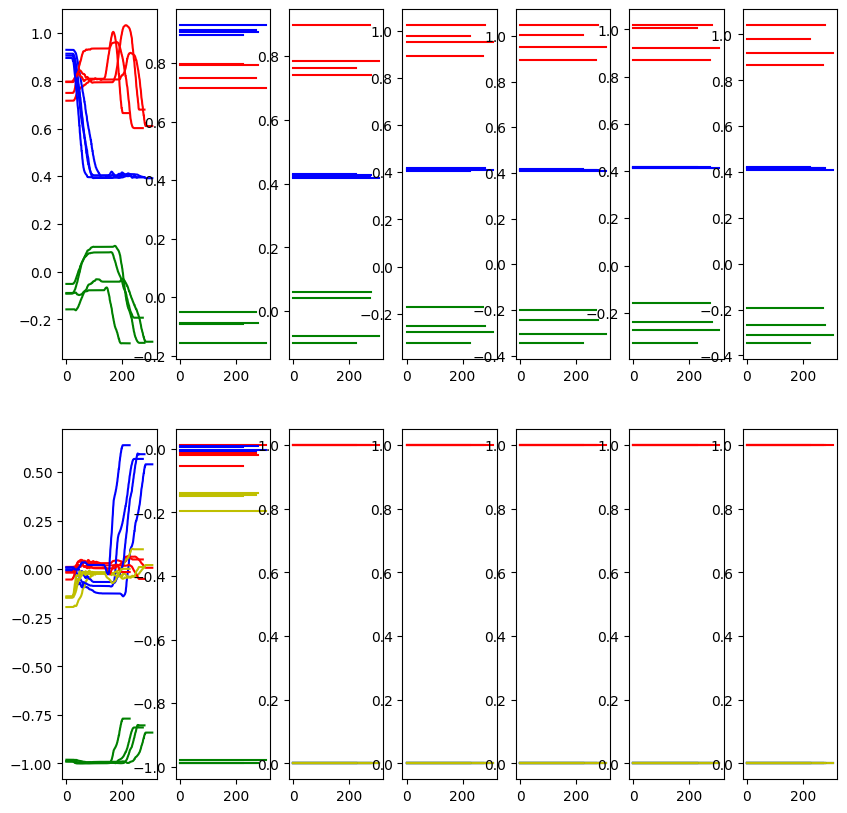

In [7]:
demos.debug_trajs()

In [8]:
tpgmm_config = TPGMMConfig(
    n_components=20,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,

    action_as_orientation=False,
    action_with_magnitude=False,

    add_gripper_action=True,

    reg_init_diag=5e-5,
    reg_diag_gripper=2e-5,
    reg_em_finish_diag_gripper=2e-5,

    reg_shrink=1e-3,
    reg_diag=5e-5,

    reg_em_finish_shrink=1e-3,
    reg_em_finish_diag=5e-5,

    fix_first_component=False,
    fix_last_component=False,

    trans_cov_mask_t_pos_corr=False,

    em_steps=1,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
)

demo_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,

    repeat_final_step=0,

    use_gripper_states=False,

    min_end_distance=35,
    min_len=4,

    velocity_threshold=0.002,
    max_idx_distance=1,
)

cascade_config = CascadeConfig(
    min_prob=0.05,
    kl_keep_rotation_dim=False
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demo_segmentation_config,
    cascade=cascade_config,
)


In [9]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2024-08-16 16:10:12.753 | INFO     |  Fitting AutoTPGMM
2024-08-16 16:10:12.753 | INFO     |  Performing fitting actions: [INIT]
2024-08-16 16:10:12.753 | INFO     |  Segmenting trajectories


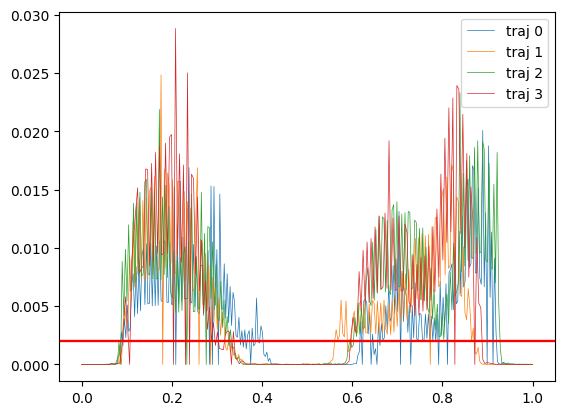

2024-08-16 16:10:12.894 | INFO     |  Creating segement of demos.
2024-08-16 16:10:12.896 | INFO     |  Subsampling to length 127 using strategy mean-length.
2024-08-16 16:10:12.897 | INFO     |  Creating segement of demos.
2024-08-16 16:10:12.899 | INFO     |  Subsampling to length 144 using strategy mean-length.
2024-08-16 16:10:12.900 | INFO     |  ... created 2 segments
2024-08-16 16:10:12.900 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:10:12.900 | INFO     |    Creating partial frame view of demos.
2024-08-16 16:10:12.906 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2024-08-16 16:10:12.906 | INFO     |    Changing number of components to 10
2024-08-16 16:10:12.906 | INFO     |    Model init ...


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:13.416 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:10:13.416 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:13.953 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:10:13.953 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:14.738 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:10:14.739 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:15.315 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:10:15.316 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:15.972 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:10:15.973 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:16.876 | INFO     |  ee_init    score (rel):     -1 (1.000)
2024-08-16 16:10:16.877 | INFO     |  kp 0       score (rel):     -1 (0.993)
2024-08-16 16:10:16.877 | INFO     |  kp 1       score (rel):     -0 (0.098)
2024-08-16 16:10:16.877 | INFO     |  kp 2       score (rel):     -0 (0.099)
2024-08-16 16:10:16.877 | INFO     |  kp 3       score (rel):     -0 (0.109)
2024-08-16 16:10:16.877 | INFO     |  kp 4       score (rel):     -0 (0.102)
2024-08-16 16:10:16.878 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:10:17.325 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:10:17.325 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:18.103 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:10:18.104 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:19.236 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:10:19.236 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:20.067 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:10:20.068 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:20.752 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:10:20.752 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:21.736 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:10:21.737 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:22.611 | INFO     |  ee_init    score (rel):     -0 (0.473)
2024-08-16 16:10:22.612 | INFO     |  kp 0       score (rel):     -1 (1.000)
2024-08-16 16:10:22.612 | INFO     |  kp 1       score (rel):     -0 (0.212)
2024-08-16 16:10:22.612 | INFO     |  kp 2       score (rel):     -0 (0.232)
2024-08-16 16:10:22.612 | INFO     |  kp 3       score (rel):     -0 (0.181)
2024-08-16 16:10:22.612 | INFO     |  kp 4       score (rel):     -0 (0.229)
2024-08-16 16:10:22.612 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:10:22.616 | INFO     |  Segmented trajs into 2 segments
2024-08-16 16:10:22.628 | INFO     |  Frame score (abs):
            ee_init     kp 0      kp 1      kp 2      kp 3      kp 4
Segment 0 -0.999780 -0.99325 -0.098202 -0.098626 -0.109157 -0.101909
Segment 1 -0.468389 -0.99076 -0.210080 -0.230067 -0.179239 -0.227226
2024-08-16 16:10:22.630 | INFO     |  Frame score (rel):
            ee_init      kp 0      kp 1      kp 2      kp 3      kp 4
S

Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-16 16:10:22.672 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

((array([[3.29e+19, 4.49e+19, 5.80e+19, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [2.97e+15, 8.58e+15, 2.34e+16, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [8.50e-16, 2.37e-13, 5.32e-11, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 2.30e+17, 1.77e+17, 1.19e+17]]),
  array([[1.73e+010, 2.31e+010, 2.96e+010, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [4.92e+005, 1.41e+006, 3.87e+006, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [1.40e-007, 1.66e-006, 1.81e-005, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         ...,
         [1.74e-244, 2.42e-240, 3.06e-236, ..., 7.84e-014, 3.13e-015,
          1.12e-016],
         [4.89e-319, 1.57e-316, 4.70e-314, ..., 5.20e+003, 1.48e+003,
          3.95e+002],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 6.99e+

In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2024-08-16 16:10:25.022 | INFO     |  Fitting AutoTPGMM
2024-08-16 16:10:25.023 | INFO     |  Segmenting trajectories


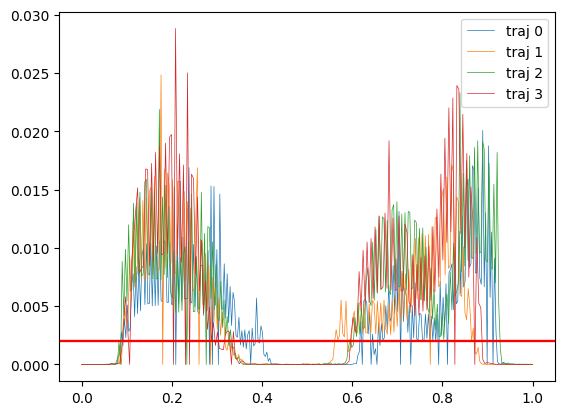

2024-08-16 16:10:25.195 | INFO     |  Creating segement of demos.
2024-08-16 16:10:25.198 | INFO     |  Creating segement of demos.
2024-08-16 16:10:25.201 | INFO     |  ... created 2 segments
2024-08-16 16:10:25.201 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:10:25.201 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:25.926 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:10:25.928 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:26.908 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:10:26.909 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:27.752 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:10:27.753 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:28.738 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:10:28.739 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:29.479 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:10:29.480 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:30.238 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:10:30.314 | INFO     |    Fitting candidate frame 1/6
2024-08-16 16:10:30.314 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:30.899 | INFO     |    Fitting candidate frame 2/6
2024-08-16 16:10:30.900 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:31.519 | INFO     |    Fitting candidate frame 3/6
2024-08-16 16:10:31.520 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:32.379 | INFO     |    Fitting candidate frame 4/6
2024-08-16 16:10:32.380 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:33.197 | INFO     |    Fitting candidate frame 5/6
2024-08-16 16:10:33.197 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:33.680 | INFO     |    Fitting candidate frame 6/6
2024-08-16 16:10:33.680 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2024-08-16 16:10:34.126 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:10:34.127 | INFO     |  Segmented trajs into 2 segments
2024-08-16 16:10:34.129 | INFO     |  Frame score (abs):
            ee_init     kp 0      kp 1      kp 2      kp 3      kp 4
Segment 0 -0.999780 -0.99325 -0.098202 -0.098626 -0.109157 -0.101909
Segment 1 -0.468389 -0.99076 -0.210080 -0.230067 -0.179239 -0.227226
2024-08-16 16:10:34.131 | INFO     |  Frame score (rel):
            ee_init      kp 0      kp 1      kp 2      kp 3      kp 4
Segment 0  1.000000  0.993468  0.098224  0.098647  0.109181  0.101931
Segment 1  0.472757  1.000000  0.212039  0.232212  0.180910  0.229345


Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

((array([[3.29e+19, 4.49e+19, 5.80e+19, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [2.97e+15, 8.58e+15, 2.34e+16, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [8.50e-16, 2.37e-13, 5.32e-11, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 2.30e+17, 1.77e+17, 1.19e+17]]),
  array([[1.73e+010, 2.31e+010, 2.96e+010, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [4.92e+005, 1.41e+006, 3.87e+006, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [1.40e-007, 1.66e-006, 1.81e-005, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         ...,
         [1.74e-244, 2.42e-240, 3.06e-236, ..., 7.84e-014, 3.13e-015,
          1.12e-016],
         [4.89e-319, 1.57e-316, 4.70e-314, ..., 5.20e+003, 1.48e+003,
          3.95e+002],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 6.99e+

In [11]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


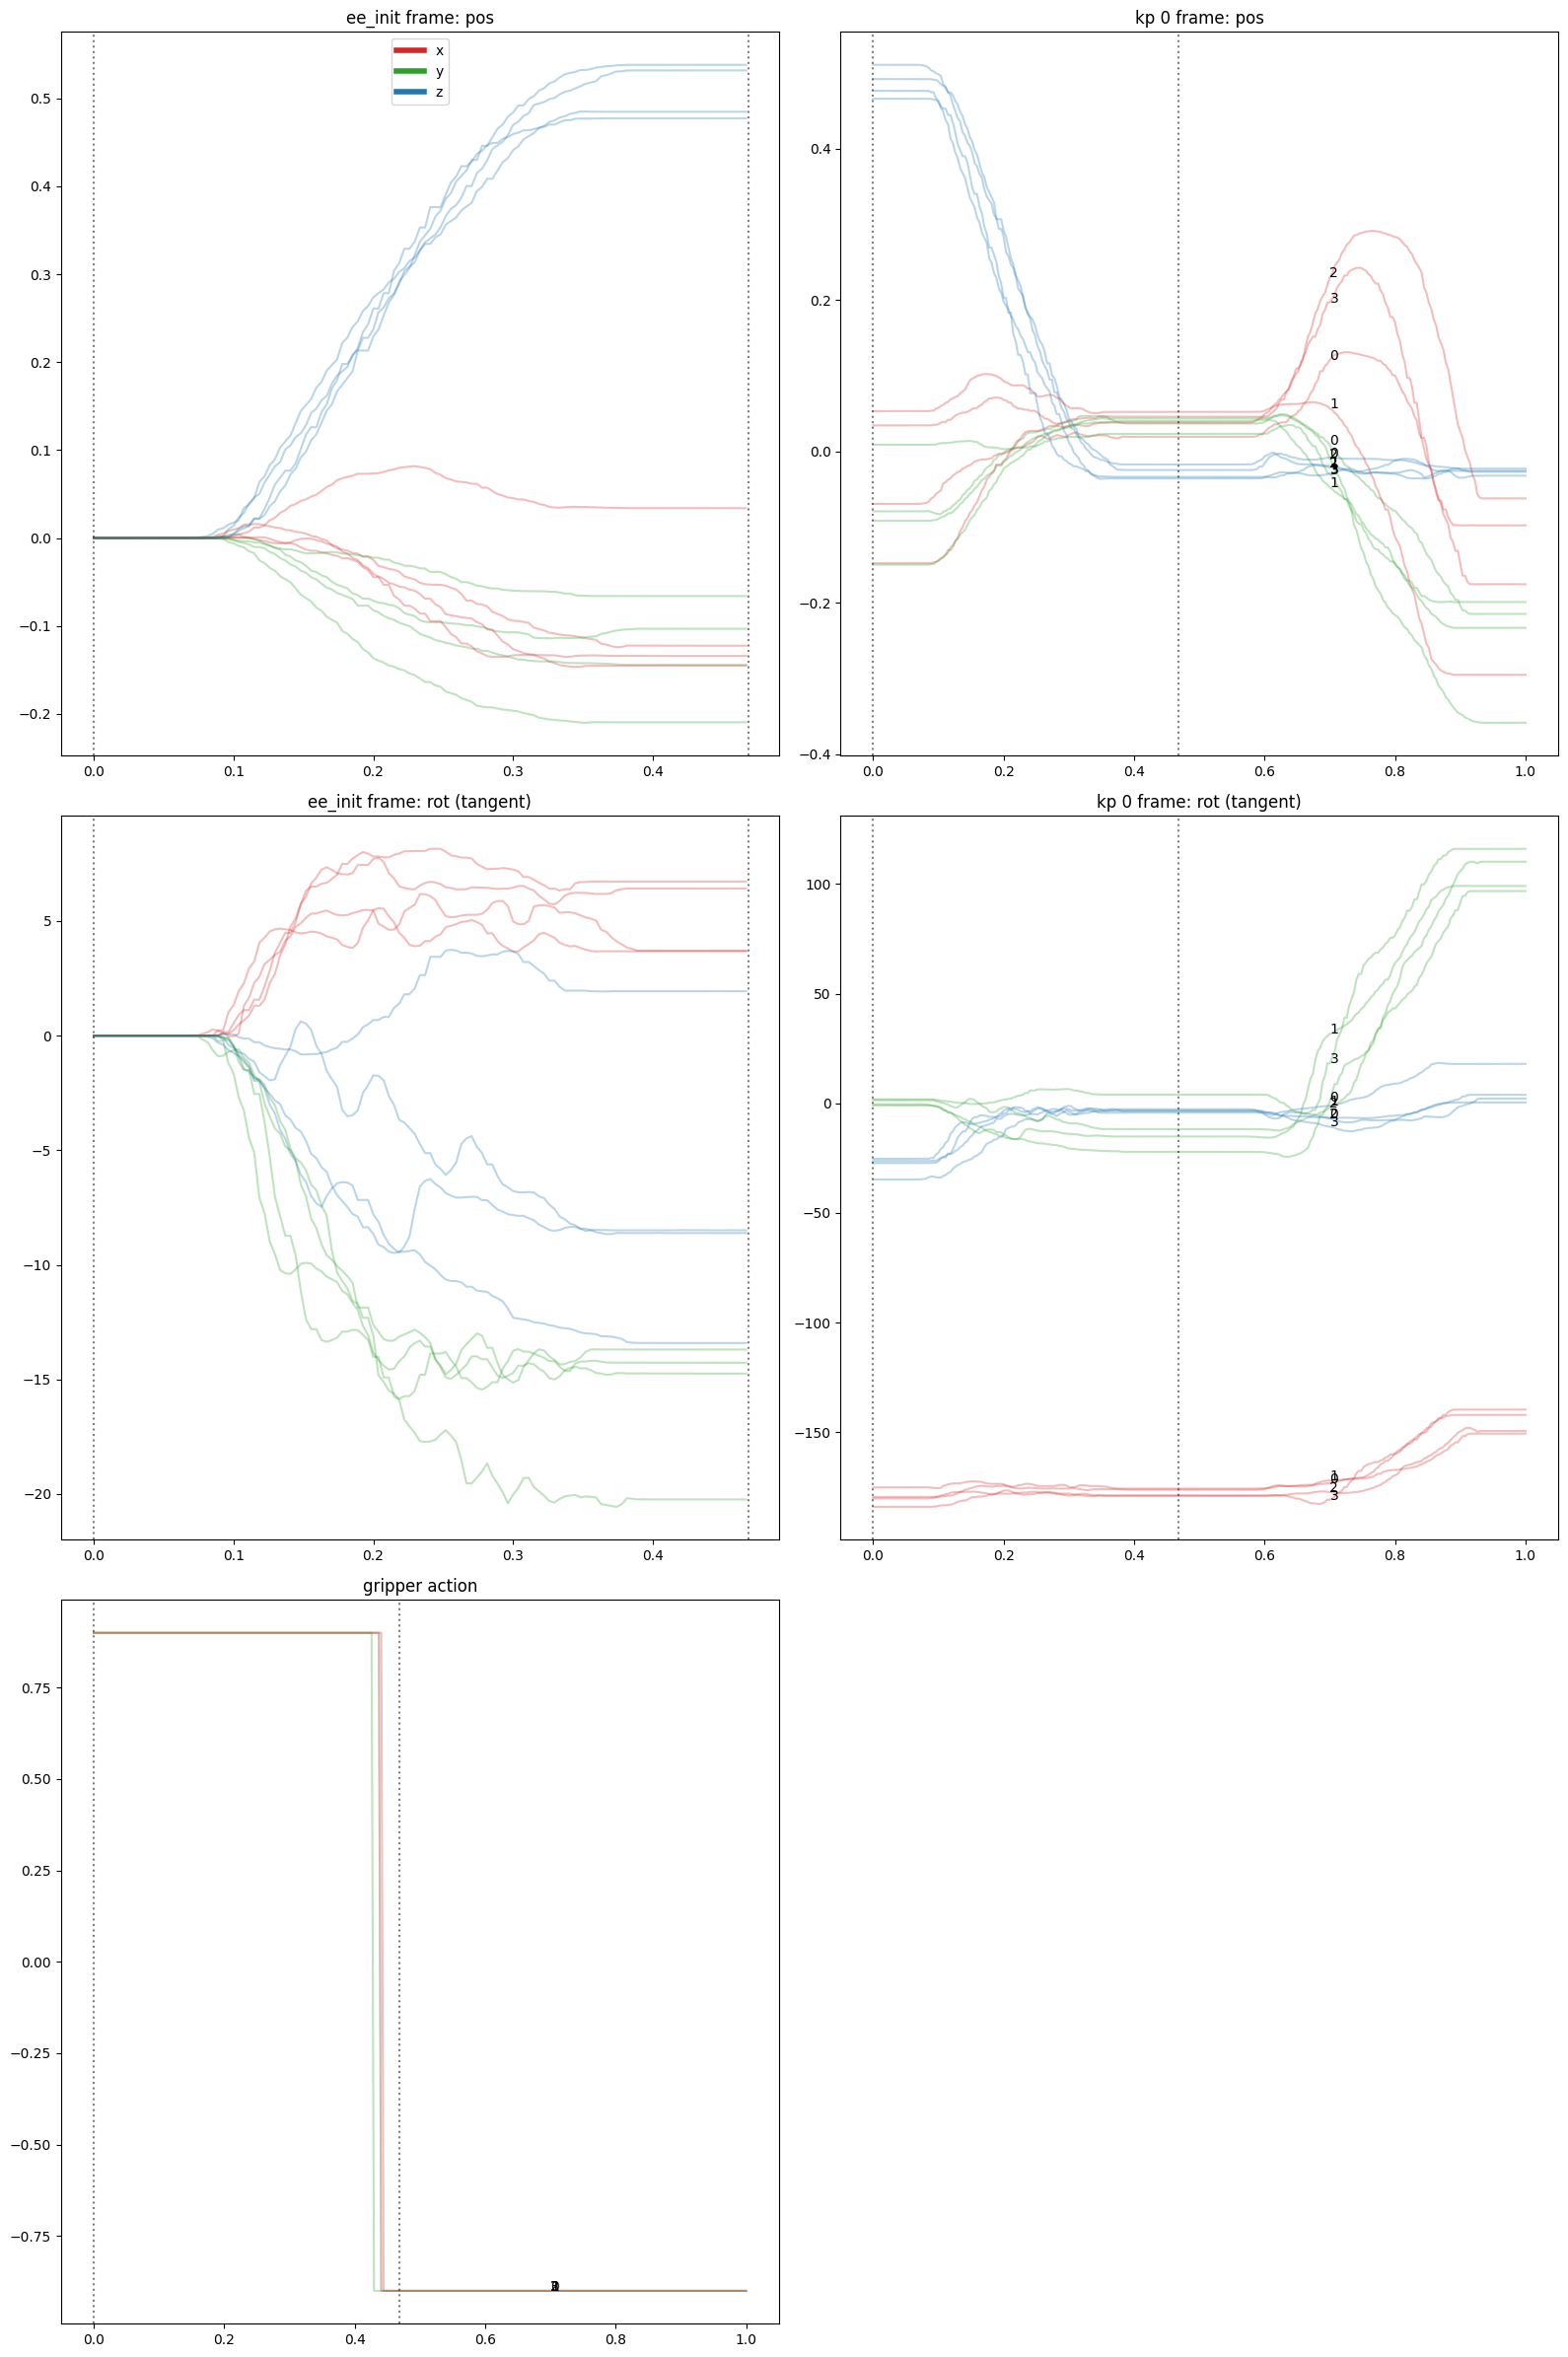

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, time_based=True,)


In [13]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.EM_HMM,))


2024-08-16 16:10:36.884 | INFO     |  Fitting AutoTPGMM
2024-08-16 16:10:36.885 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

2024-08-16 16:10:36.893 | INFO     |  HMM EM ...
2024-08-16 16:10:36.899 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

2024-08-16 16:10:37.050 | INFO     |  HMM init priors not defined, initializing to uniform
2024-08-16 16:10:40.018 | WARNING  |  HMM EM did not converge


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

((array([[1.00e+00, 1.00e+00, 1.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [9.04e-05, 1.91e-04, 4.02e-04, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [2.58e-35, 5.28e-33, 9.17e-31, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.00e+00, 1.00e+00, 1.00e+00]]),
  array([[1.00e+000, 1.00e+000, 1.00e+000, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [2.85e-005, 6.12e-005, 1.31e-004, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [8.09e-018, 7.16e-017, 6.13e-016, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         ...,
         [1.01e-254, 1.05e-250, 1.03e-246, ..., 1.12e-022, 6.05e-024,
          3.09e-025],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 7.44e-006, 2.86e-006,
          1.09e-006],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.00e+

2024-08-16 16:10:42.678 | INFO     |  Did not specify time_based, deciding automatically.
2024-08-16 16:10:42.804 | WARNING  |  Skippig NaN Gaussians.


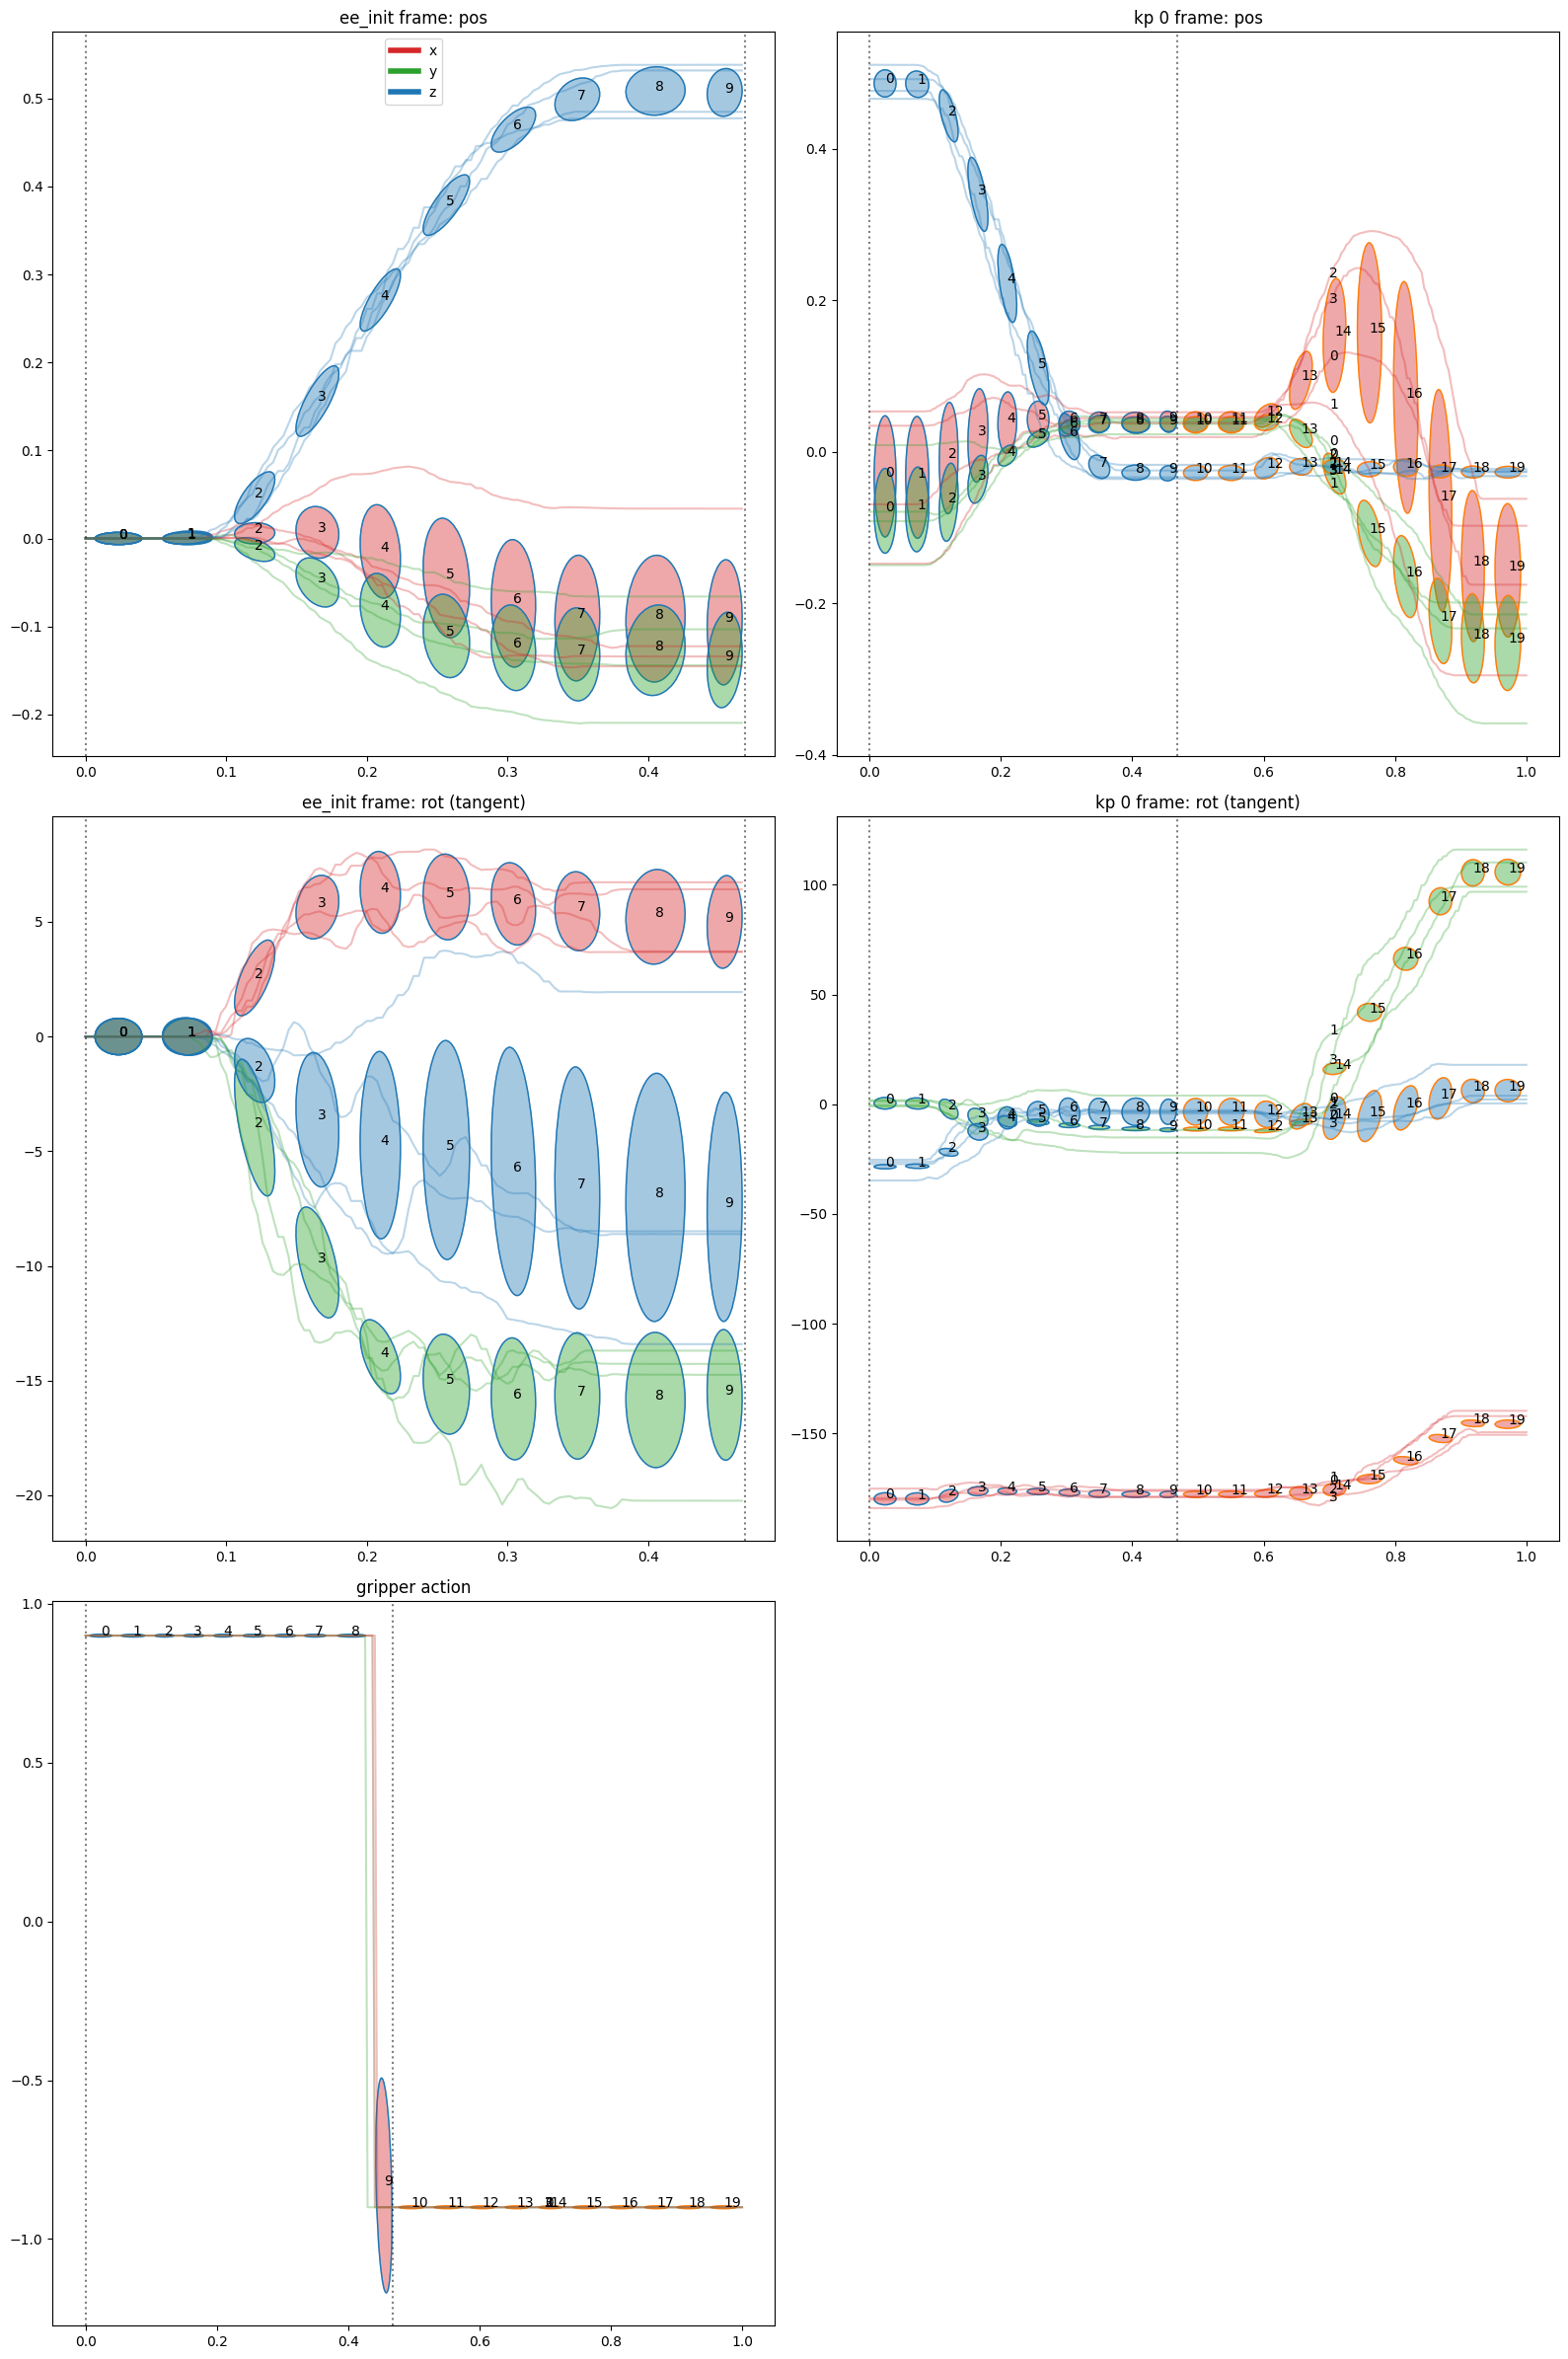

In [14]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False)


In [15]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2024-08-16 16:10:45.476 | INFO     |  Saving model:


2024-08-16 16:10:45.610 | INFO     |  Did not specify time_based, deciding automatically.


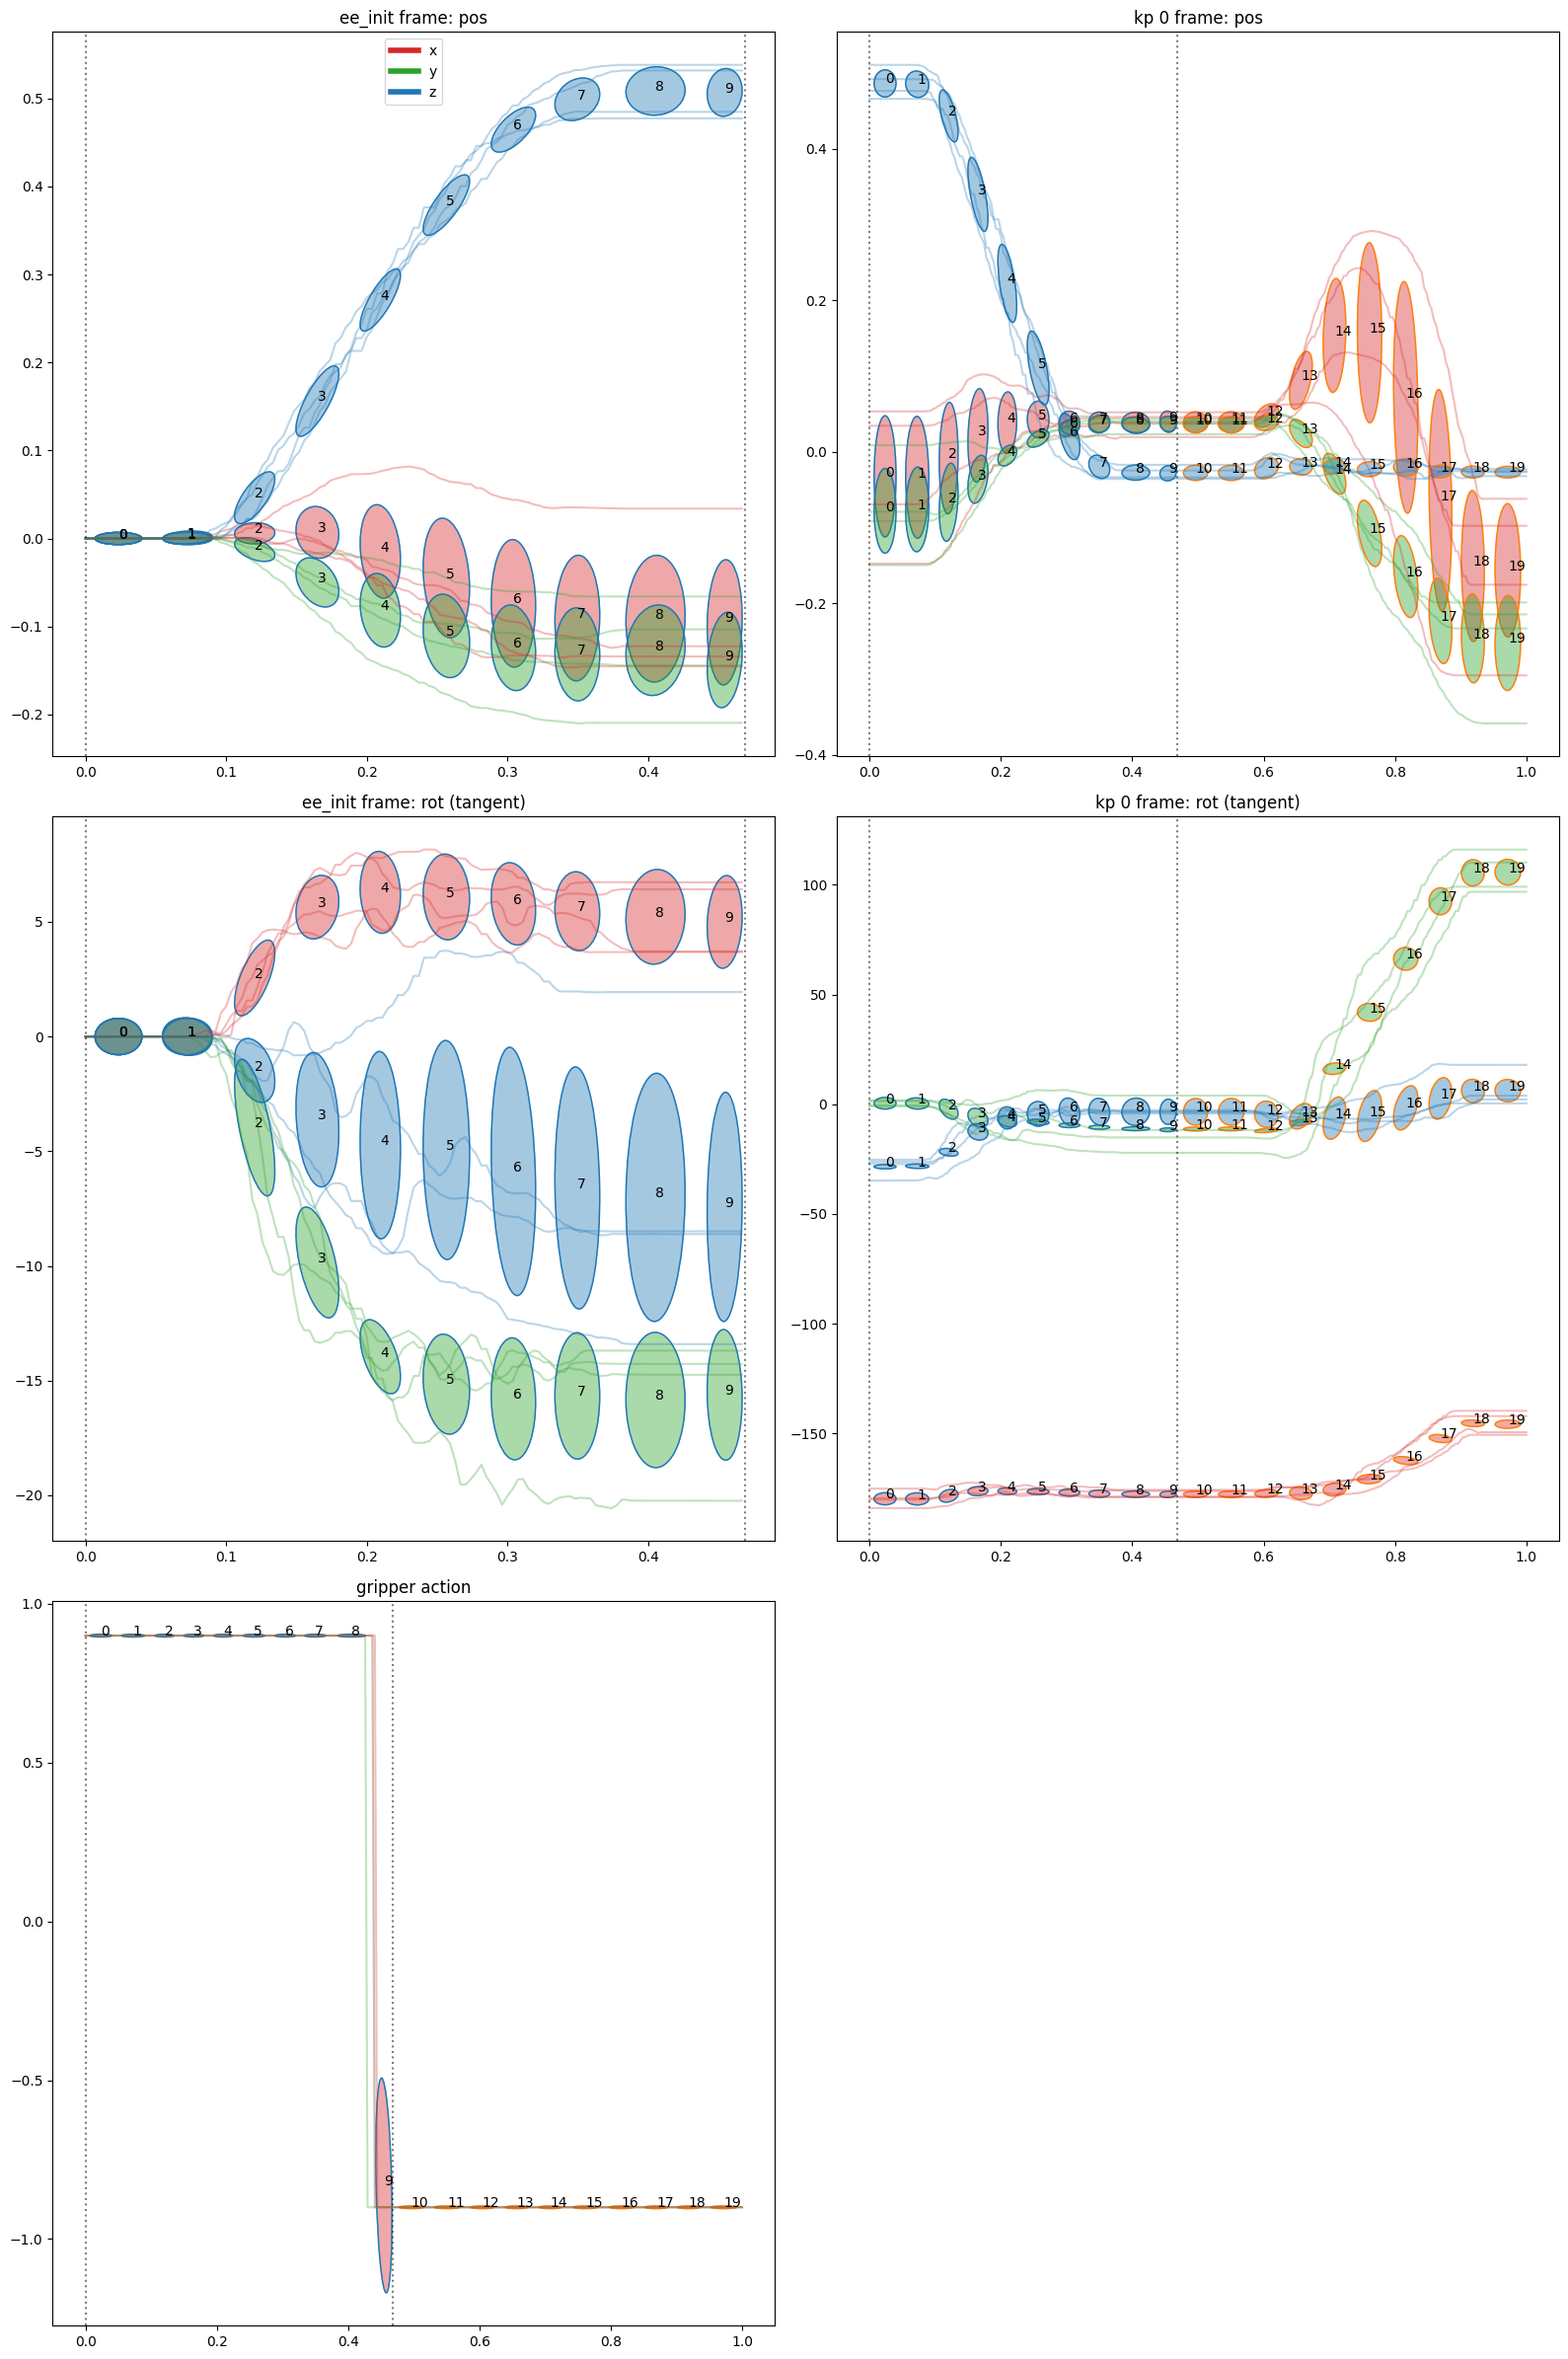

In [16]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False)


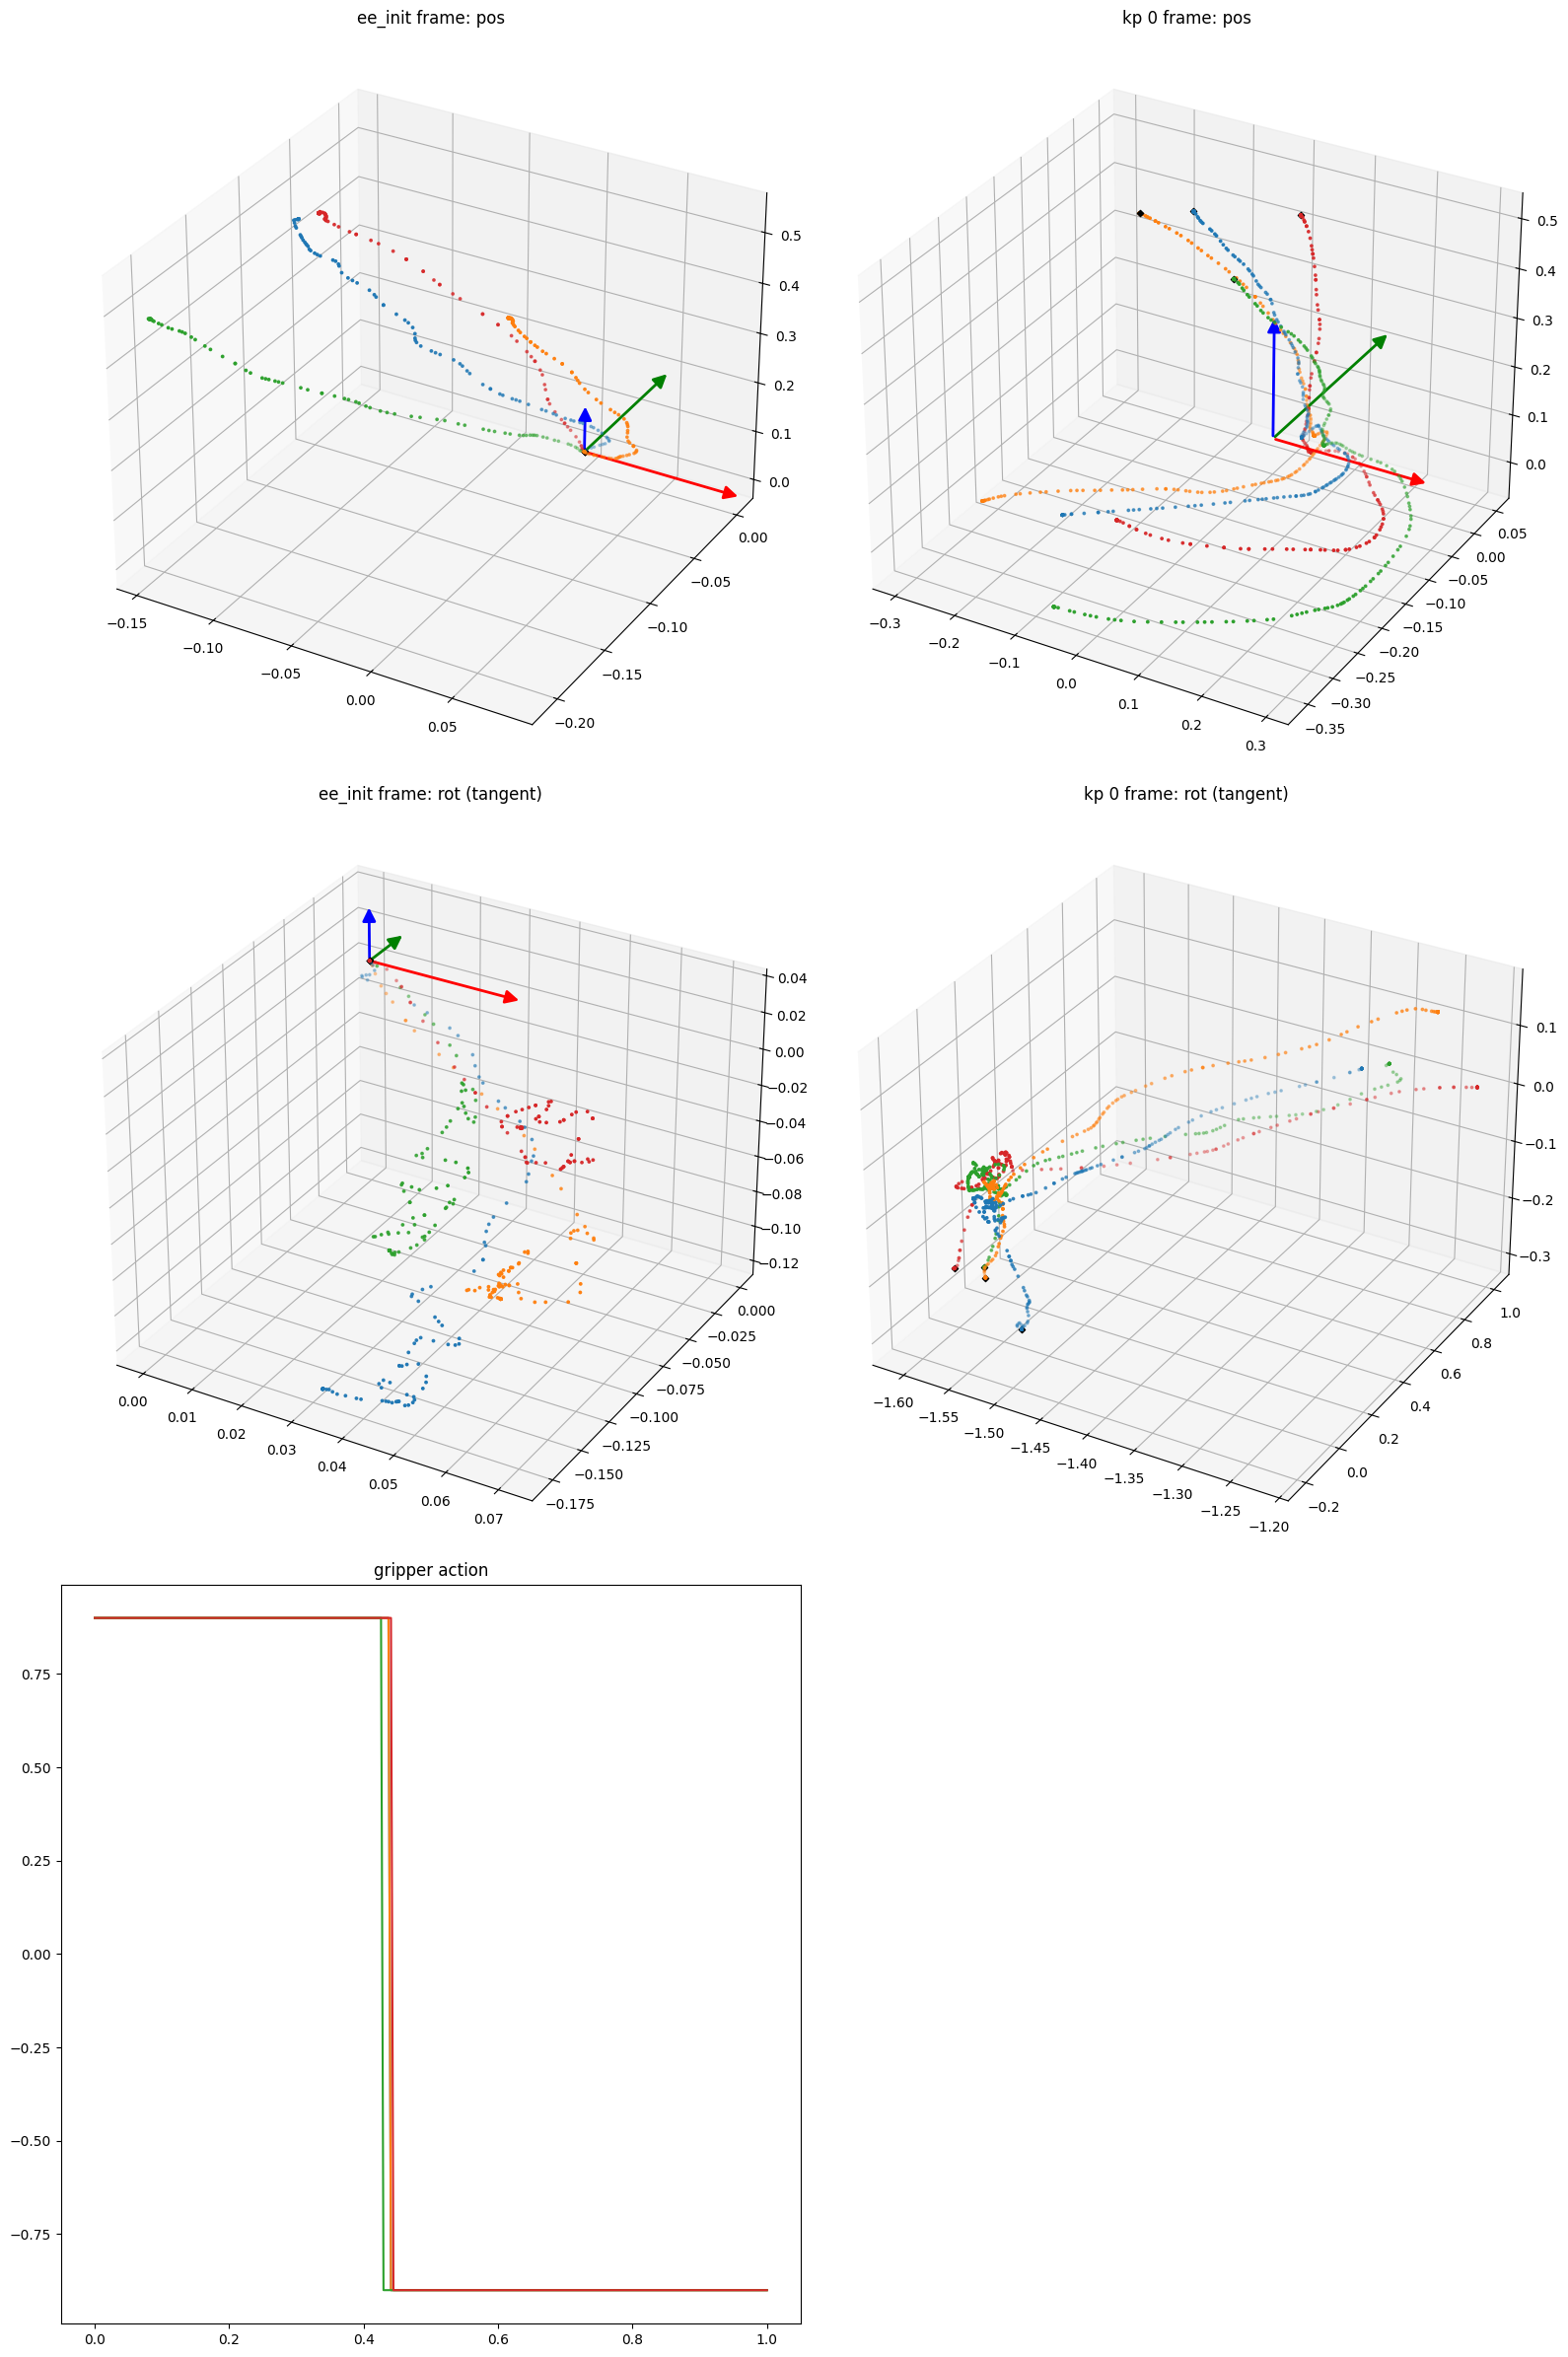

In [17]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

In [18]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2024-08-16 16:10:49.922 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2024-08-16 16:10:49.934 | INFO     |  Caculated segment transition probabilities: (array([[0.99]]),)
2024-08-16 16:10:49.935 | INFO     |  Creating partial frame view of demos.
2024-08-16 16:10:50.221 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:10:50.422 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2024-08-16 16:10:50.522 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/4 [00:00<?, ?it/s]

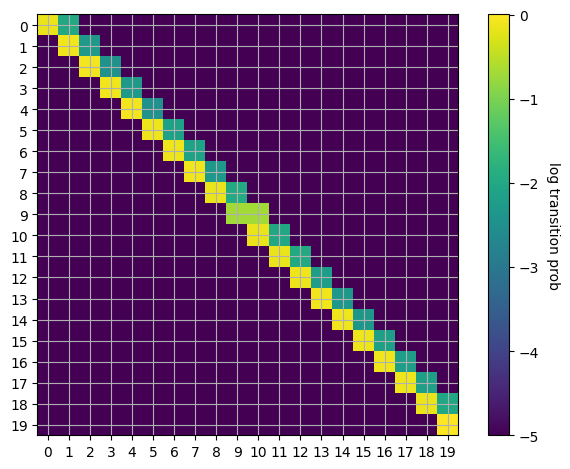

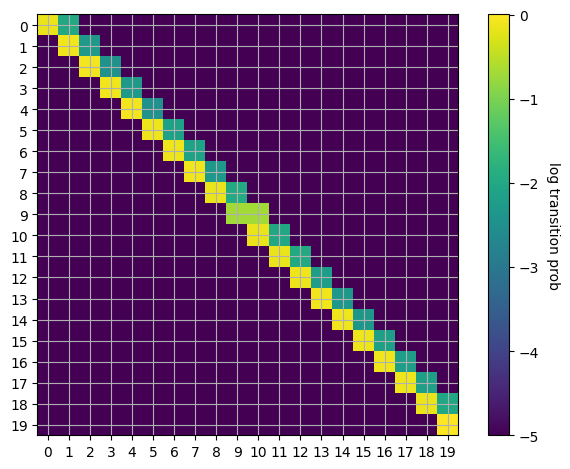

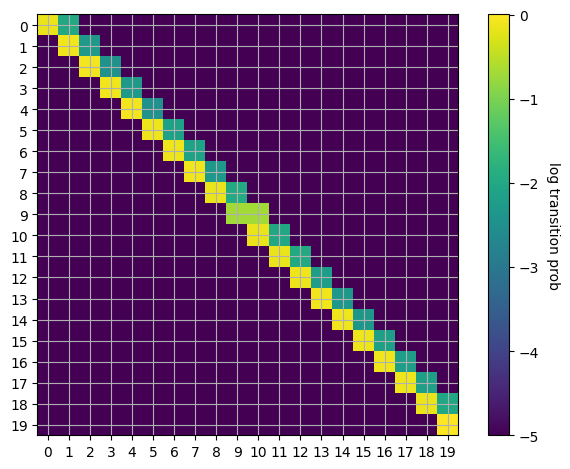

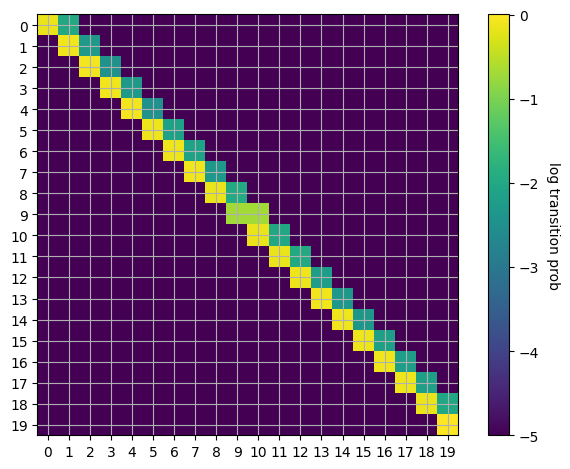

In [19]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)


2024-08-16 16:11:15.115 | INFO     |  Taking frame origins from demos.


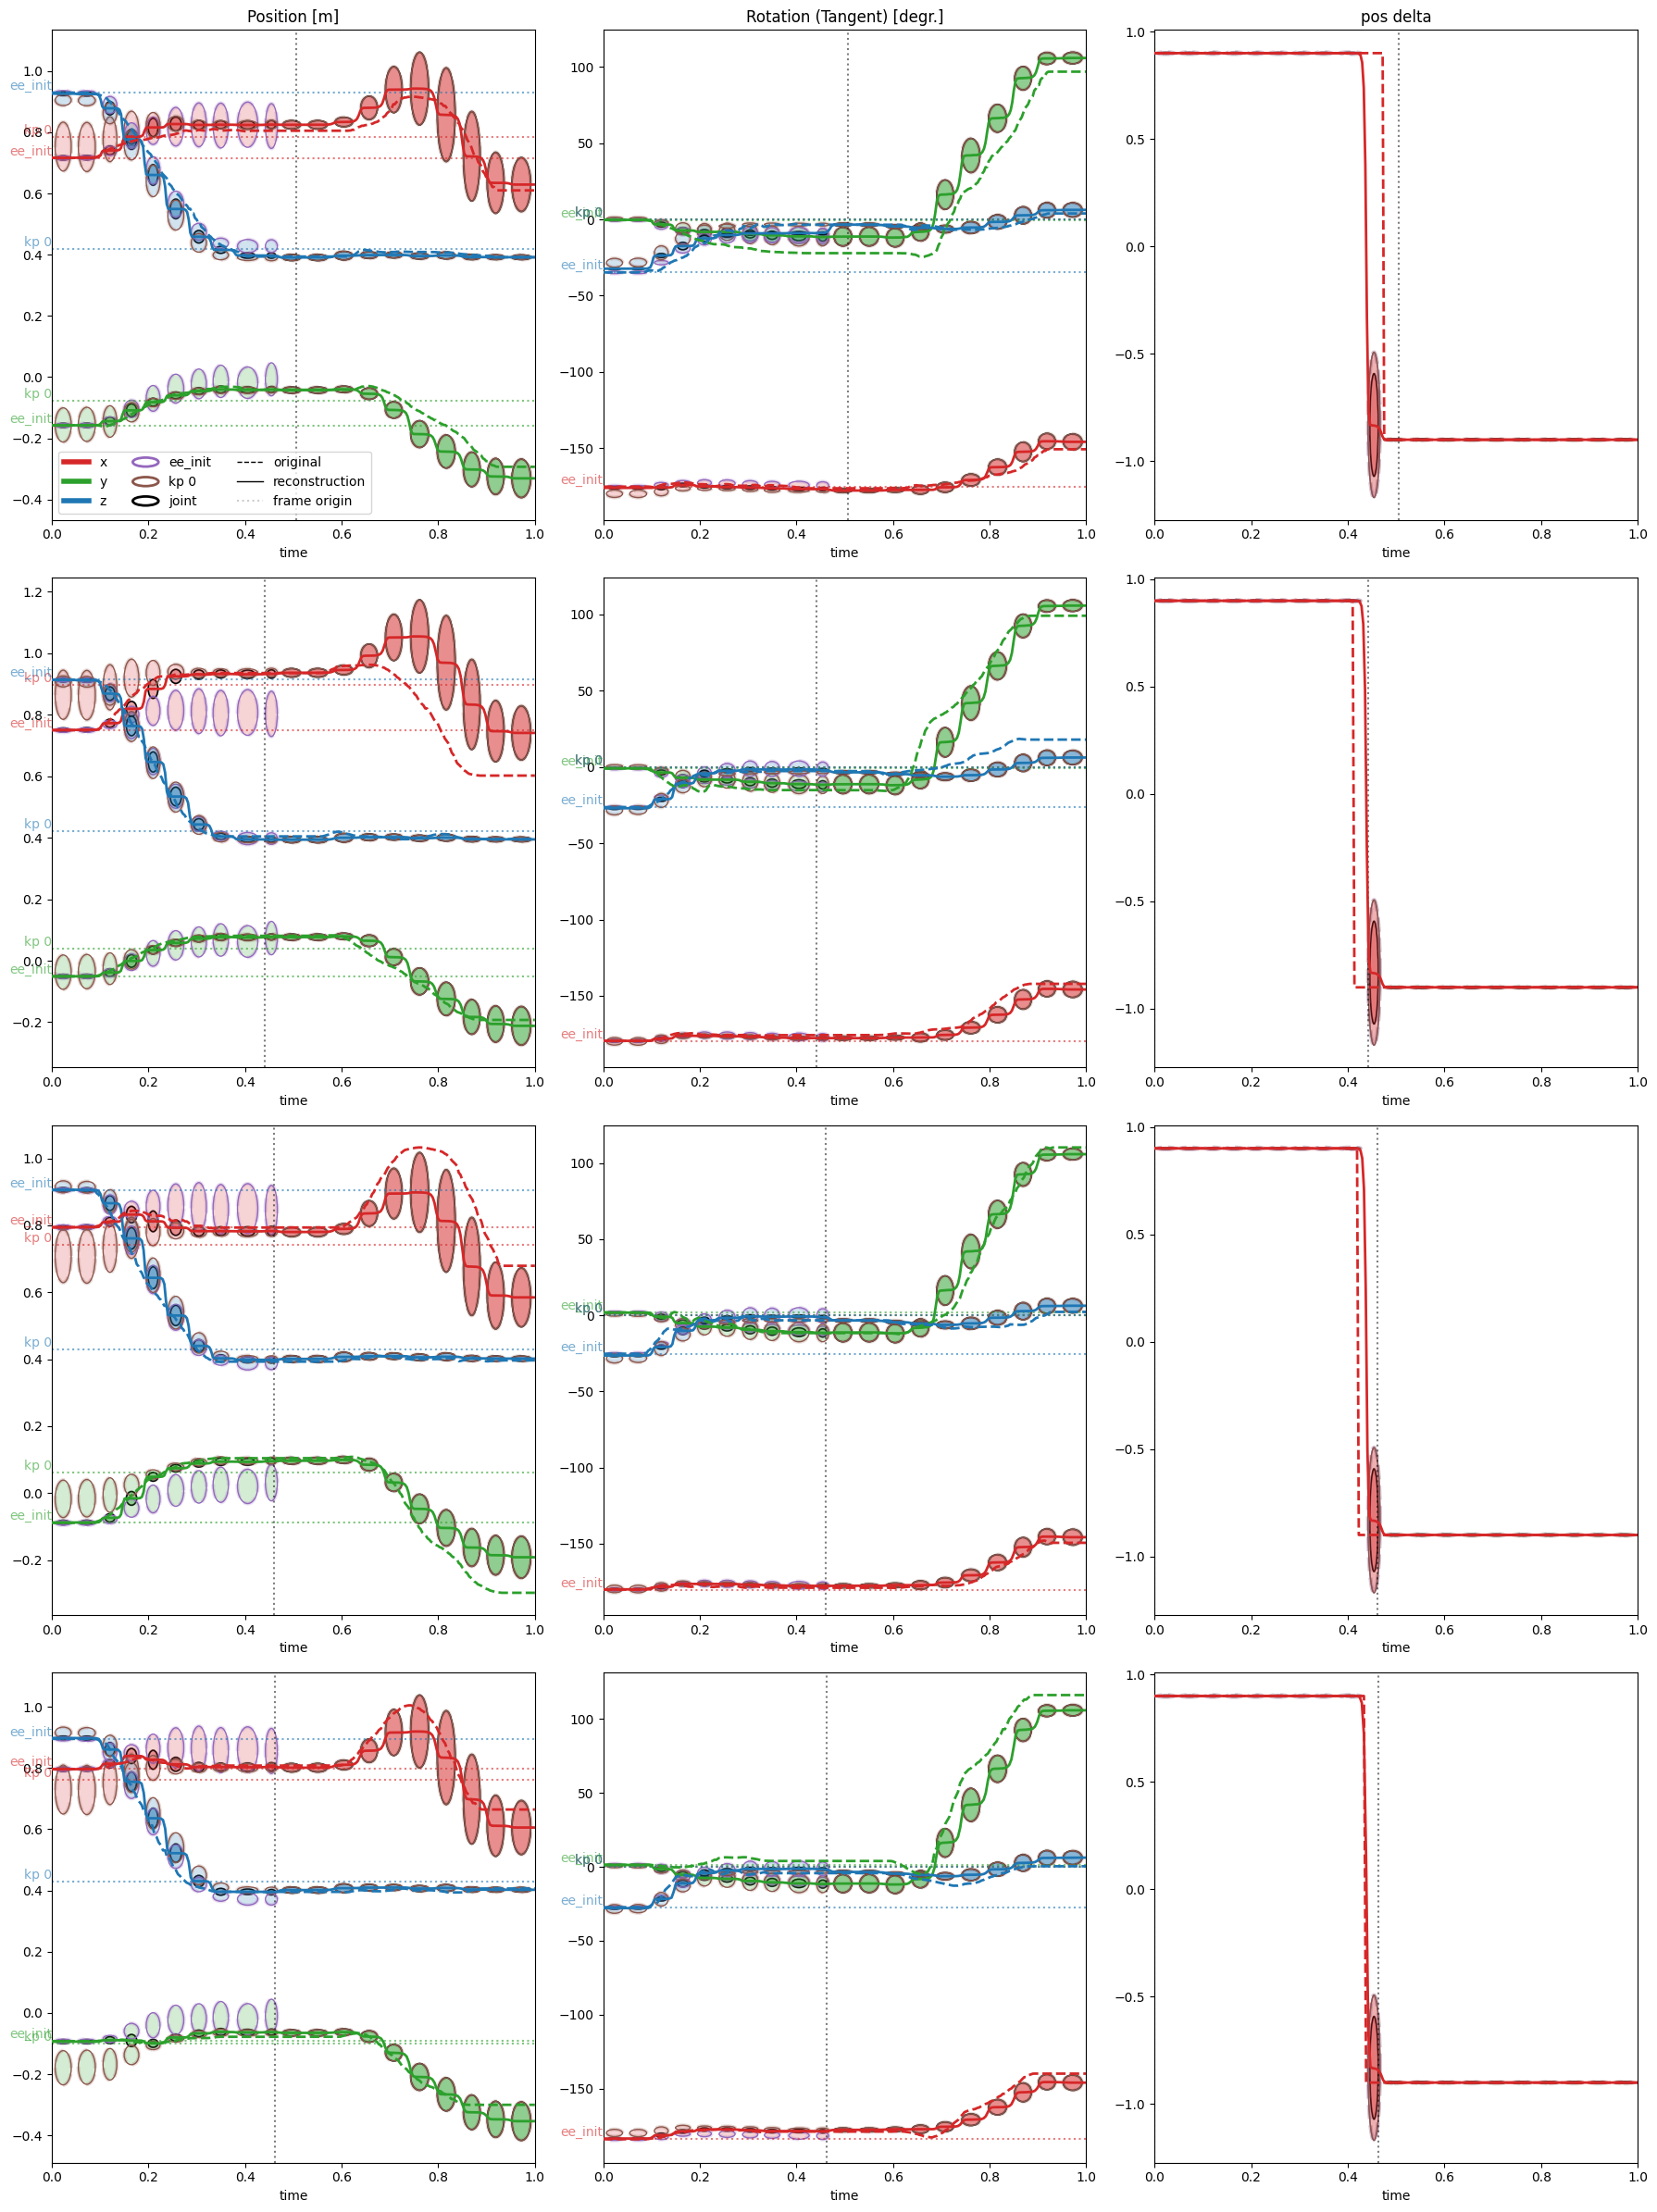

In [20]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


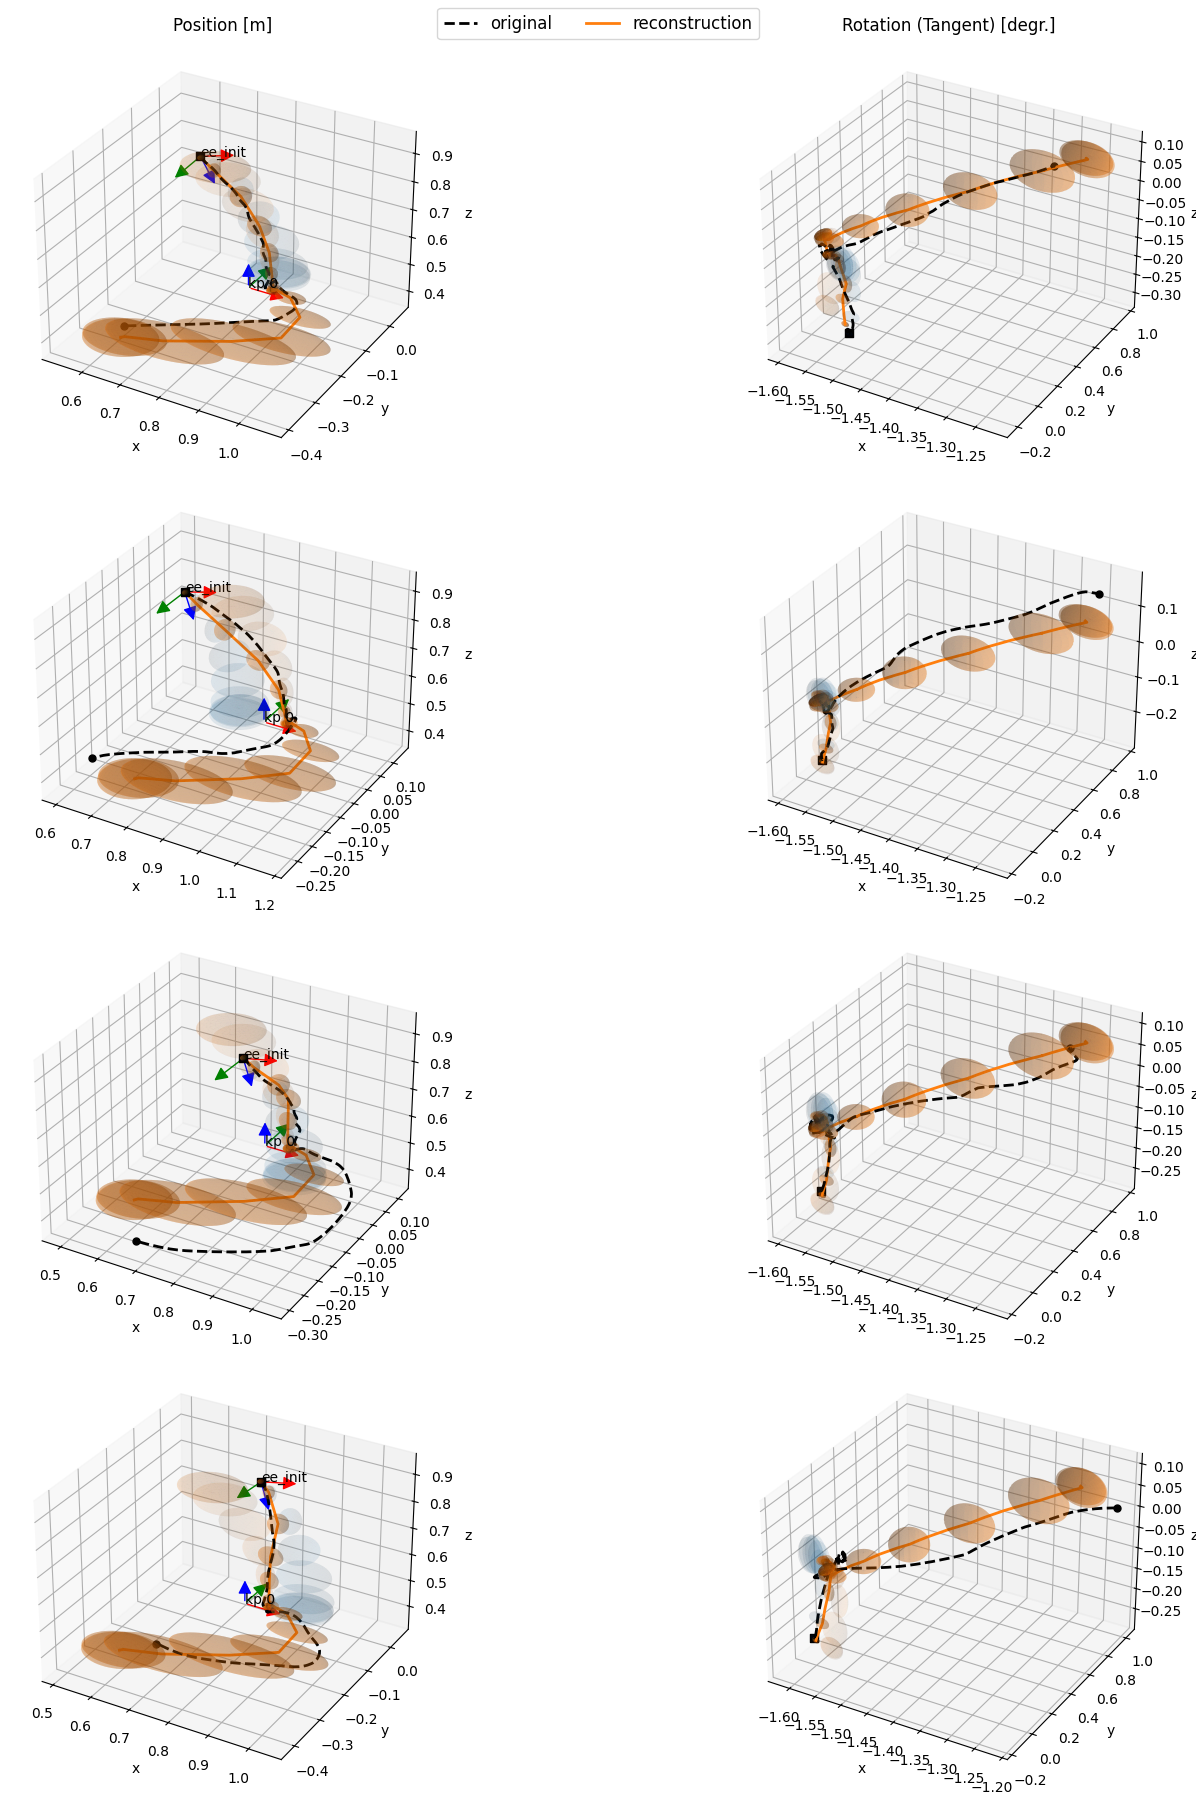

In [21]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=False, per_segment=False)